In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/MyDrive/pracimg

/content/gdrive/MyDrive/pracimg


In [ ]:
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets

In [ ]:
import os
os.getcwd()
os.chdir('./')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/pracimg'

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch

data_dir = "./"

def create_datasets(batch_size):
    
    train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 좌우반전 
    # transforms.RandomVerticalFlip(),  # 상하반전 
    transforms.Resize((256, 256)),  # 알맞게 변경하세요 
    transforms.ToTensor(),  # 이 과정에서 [0, 255]의 범위를 갖는 값들을 [0.0, 1.0]으로 정규화, torch.FloatTensor로 변환
    transforms.Normalize([0.43303847,0.4034577, 0.39415097], [0.18344551,0.17549995, 0.1647388])  #  정규화(normalization)
])
    # choose the training and test datasets
    train_data = datasets.ImageFolder(root='./', transform=train_transform)


    # trainning set 중 validation 데이터로 사용할 비율
    valid_size = 0.3

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # trainning, validation batch를 얻기 위한 sampler정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=4)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=4)

    return train_data, train_loader, valid_loader

train 데이터셋 크기: 39
클래스: ['katsura', 'yuri']


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


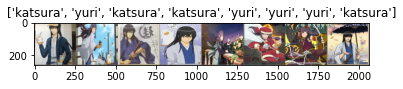

torch.Size([8, 3, 256, 256])


In [ ]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

train_data, train_loader, valid_loader = create_datasets(batch_size=8)


print('train 데이터셋 크기:', len(train_data))

class_names = train_data.classes
print('클래스:', class_names)

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.43303847, 0.4034577, 0.39415097])
    std = np.array([0.18344551, 0.17549995, 0.1647388])
    input = std * input + mean
    input = np.clip(input, 0, 1)

    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_loader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print(inputs.shape)

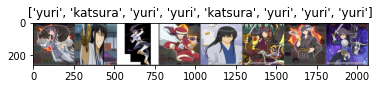

torch.Size([8, 3, 256, 256])


In [ ]:
iterator = iter(valid_loader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print(inputs.shape)

In [ ]:
print('train_data 사이즈 : ',len(train_loader.sampler.indices))
print('valid data 사이즈 : ',len(valid_loader.sampler.indices))

train_data 사이즈 :  28
valid data 사이즈 :  11


In [ ]:
# 이미지 cnn 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)     #  (256,256,3) -> (252,252,6)
    self.pool1 = nn.MaxPool2d(2,2)    #  (252,252,6) -> (126,126,6)
    self.conv2 = nn.Conv2d(6,16,5)    #  (126,126,6) -> (122,122,16)
    self.pool2 = nn.MaxPool2d(2,2)    #  (122,122,16) -> (61,61,16)
    self.fc1 = nn.Linear(16*61*61,120) 
    self.fc2 = nn.Linear(120,10)
  
  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,16*61*61)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return x

net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=1e-3,momentum=0.9)
optimizer2 = optim.Adam(net.parameters(),lr=0.001,weight_decay=1e-7)

In [ ]:
loss_ = []
n = len(train_loader)

for epoch in range(100):
  running_loss = 0.0
  for i,data in enumerate(train_loader):
    inputs,labels = data[0].to(device), data[1].to(device)
    
    optimizer.zero_grad()
    
    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  loss_.append(running_loss/n)
  print('[%d] loss: %.3f' %(epoch+1,running_loss/len(train_loader)))

print('Finished Training')

[1] loss: 0.033
[2] loss: 0.019
[3] loss: 0.015
[4] loss: 0.007
[5] loss: 0.007
[6] loss: 0.004
[7] loss: 0.006
[8] loss: 0.003
[9] loss: 0.002
[10] loss: 0.002
[11] loss: 0.002
[12] loss: 0.002
[13] loss: 0.001
[14] loss: 0.002
[15] loss: 0.001
[16] loss: 0.002
[17] loss: 0.001
[18] loss: 0.001
[19] loss: 0.001
[20] loss: 0.001
[21] loss: 0.001
[22] loss: 0.001
[23] loss: 0.001
[24] loss: 0.001
[25] loss: 0.001
[26] loss: 0.001
[27] loss: 0.001
[28] loss: 0.001
[29] loss: 0.001
[30] loss: 0.001
[31] loss: 0.001
[32] loss: 0.001
[33] loss: 0.001
[34] loss: 0.001
[35] loss: 0.001
[36] loss: 0.001
[37] loss: 0.000
[38] loss: 0.001
[39] loss: 0.001
[40] loss: 0.000
[41] loss: 0.000
[42] loss: 0.001
[43] loss: 0.000
[44] loss: 0.000
[45] loss: 0.000
[46] loss: 0.000
[47] loss: 0.000
[48] loss: 0.000
[49] loss: 0.000
[50] loss: 0.000
[51] loss: 0.000
[52] loss: 0.000
[53] loss: 0.000
[54] loss: 0.001
[55] loss: 0.000
[56] loss: 0.000
[57] loss: 0.000
[58] loss: 0.000
[59] loss: 0.000
[60] l

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in valid_loader:
    images,labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100*correct/total))

Accuracy of the network on the test images: 72 %


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


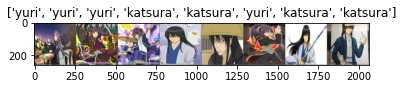

torch.Size([8, 3, 256, 256])


In [ ]:
iterator = iter(valid_loader)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print(inputs.shape)


In [ ]:
outputs = net(inputs.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)

In [ ]:
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]}' for j in range(8)))

Predicted:  katsura yuri katsura yuri yuri yuri yuri katsura


In [ ]:
# 이미지 RNN

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
torch.backends.cudnn.enabled = False

In [ ]:
input_size = 256*3
hidden_size = 1000
sequence_length = 256
num_layers = 4
class VanillaRNN(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super().__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,2),nn.Sigmoid())
  
  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size()[0],self.hidden_size).to(self.device)
    out,_ = self.rnn(x,h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out
  
model = VanillaRNN(input_size = input_size, hidden_size = hidden_size, sequence_length = sequence_length, num_layers = num_layers,device=device).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)
optimizer2 = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-7)

In [ ]:
loss_ = []
n = len(train_loader)

for epoch in range(100):
  running_loss = 0.0
  for i,(inputs,labels) in enumerate(train_loader):
    inputs = inputs.view(-1, sequence_length, input_size)
    inputs = inputs.to(device)
    labels = labels.to(device) 

    optimizer.zero_grad()   
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  loss_.append(running_loss/n)
  print('[%d] loss: %.3f' %(epoch+1,running_loss/len(train_loader)))

print('Finished Training')

[1] loss: 0.347
[2] loss: 0.343
[3] loss: 0.340
[4] loss: 0.333
[5] loss: 0.331
[6] loss: 0.329
[7] loss: 0.326
[8] loss: 0.324
[9] loss: 0.323
[10] loss: 0.322
[11] loss: 0.321
[12] loss: 0.321
[13] loss: 0.320
[14] loss: 0.320
[15] loss: 0.320
[16] loss: 0.319
[17] loss: 0.318
[18] loss: 0.318
[19] loss: 0.318
[20] loss: 0.318
[21] loss: 0.318
[22] loss: 0.317
[23] loss: 0.317
[24] loss: 0.317
[25] loss: 0.318
[26] loss: 0.317
[27] loss: 0.317
[28] loss: 0.317
[29] loss: 0.317
[30] loss: 0.317
[31] loss: 0.317
[32] loss: 0.316
[33] loss: 0.316
[34] loss: 0.316
[35] loss: 0.316
[36] loss: 0.316
[37] loss: 0.316
[38] loss: 0.316
[39] loss: 0.316
[40] loss: 0.315
[41] loss: 0.316
[42] loss: 0.315
[43] loss: 0.315
[44] loss: 0.315
[45] loss: 0.315
[46] loss: 0.315
[47] loss: 0.315
[48] loss: 0.315
[49] loss: 0.315
[50] loss: 0.315
[51] loss: 0.315
[52] loss: 0.315
[53] loss: 0.315
[54] loss: 0.315
[55] loss: 0.315
[56] loss: 0.315
[57] loss: 0.315
[58] loss: 0.315
[59] loss: 0.315
[60] l

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in valid_loader:
    images = data[0].to(device)
    images = images.view(-1, sequence_length, input_size).to(device)
    labels = data[1].to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100*correct/total))

Accuracy of the network on the test images: 81 %


In [ ]:
# Bi-directional LSTM

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
input_size = 256*3
hidden_size = 1000
sequence_length = 256
num_layers = 4
class BiLSTM(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super().__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,bidirectional=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length*2,2),nn.Sigmoid())
  
  def forward(self,x):
    h0 = torch.zeros(self.num_layers*2, x.size()[0],self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers*2, x.size()[0],self.hidden_size).to(self.device)
    out,_ = self.rnn(x,(h0,c0))
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out
  
model = BiLSTM(input_size = input_size, hidden_size = hidden_size, sequence_length = sequence_length, num_layers = num_layers,device=device).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)
optimizer2 = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-7)

In [ ]:
loss_ = []
n = len(train_loader)

for epoch in range(100):
  running_loss = 0.0
  for i,(inputs,labels) in enumerate(train_loader):
    inputs = inputs.view(-1, sequence_length, input_size)
    inputs = inputs.to(device)
    labels = labels.to(device) 

    optimizer.zero_grad()   
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  loss_.append(running_loss/n)
  print('[%d] loss: %.3f' %(epoch+1,running_loss/len(train_loader)))

print('Finished Training')

[1] loss: 0.691
[2] loss: 0.684
[3] loss: 0.675
[4] loss: 0.657
[5] loss: 0.650
[6] loss: 0.633
[7] loss: 0.624
[8] loss: 0.612
[9] loss: 0.604
[10] loss: 0.596
[11] loss: 0.608
[12] loss: 0.580
[13] loss: 0.585
[14] loss: 0.577
[15] loss: 0.574
[16] loss: 0.578
[17] loss: 0.576
[18] loss: 0.560
[19] loss: 0.547
[20] loss: 0.564
[21] loss: 0.552
[22] loss: 0.542
[23] loss: 0.543
[24] loss: 0.539
[25] loss: 0.551
[26] loss: 0.541
[27] loss: 0.548
[28] loss: 0.523
[29] loss: 0.509
[30] loss: 0.535
[31] loss: 0.508
[32] loss: 0.499
[33] loss: 0.514
[34] loss: 0.505
[35] loss: 0.492
[36] loss: 0.491
[37] loss: 0.499
[38] loss: 0.496
[39] loss: 0.481
[40] loss: 0.480
[41] loss: 0.477
[42] loss: 0.476
[43] loss: 0.481
[44] loss: 0.468
[45] loss: 0.482
[46] loss: 0.469
[47] loss: 0.464
[48] loss: 0.471
[49] loss: 0.462
[50] loss: 0.453
[51] loss: 0.461
[52] loss: 0.454
[53] loss: 0.448
[54] loss: 0.450
[55] loss: 0.456
[56] loss: 0.439
[57] loss: 0.442
[58] loss: 0.432
[59] loss: 0.429
[60] l

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in valid_loader:
    images = data[0].to(device)
    images = images.view(-1, sequence_length, input_size).to(device)
    labels = data[1].to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100*correct/total))

Accuracy of the network on the test images: 45 %


In [ ]:
# 전이학습

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch

data_dir = "./"

def create_datasets(batch_size):
    
    train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 좌우반전 
    # transforms.RandomVerticalFlip(),  # 상하반전 
    transforms.Resize((32, 32)),  # 알맞게 변경하세요 
    transforms.ToTensor(),  # 이 과정에서 [0, 255]의 범위를 갖는 값들을 [0.0, 1.0]으로 정규화, torch.FloatTensor로 변환
    transforms.Normalize([0.43303847,0.4034577, 0.39415097], [0.18344551,0.17549995, 0.1647388])  #  정규화(normalization)
])
    # choose the training and test datasets
    train_data = datasets.ImageFolder(root='./', transform=train_transform)


    # trainning set 중 validation 데이터로 사용할 비율
    valid_size = 0.3

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # trainning, validation batch를 얻기 위한 sampler정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=4)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=4)

    return train_data, train_loader, valid_loader

train 데이터셋 크기: 39
클래스: ['katsura', 'yuri']


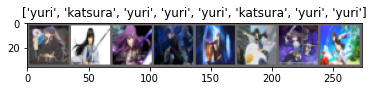

torch.Size([8, 3, 32, 32])


In [ ]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

train_data, train_loader, valid_loader = create_datasets(batch_size=8)


print('train 데이터셋 크기:', len(train_data))

class_names = train_data.classes
print('클래스:', class_names)

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.43303847, 0.4034577, 0.39415097])
    std = np.array([0.18344551, 0.17549995, 0.1647388])
    input = std * input + mean
    input = np.clip(input, 0, 1)

    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_loader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print(inputs.shape)

In [ ]:
model = torchvision.models.resnet18(pretrained=True).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.to(device)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4,weight_decay = 1e-2)

In [ ]:
loss_ = []
n = len(train_loader)

for epoch in range(100):
  running_loss = 0.0

  for data in train_loader:
    inputs,labels = data[0].to(device),data[1].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  
  cost = running_loss/len(train_loader)
  print(f'[{epoch+1}] loss: {cost:.3f}')

torch.save(model.state_dict(),'prec_resnet18.pth')

print('Finished Training')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1] loss: 0.790
[2] loss: 0.505
[3] loss: 0.429
[4] loss: 0.351
[5] loss: 0.375
[6] loss: 0.486
[7] loss: 0.393
[8] loss: 0.202
[9] loss: 0.263
[10] loss: 0.316
[11] loss: 0.134
[12] loss: 0.439
[13] loss: 0.040
[14] loss: 0.312
[15] loss: 0.147
[16] loss: 0.414
[17] loss: 0.333
[18] loss: 0.057
[19] loss: 0.100
[20] loss: 0.215
[21] loss: 0.121
[22] loss: 0.106
[23] loss: 0.074
[24] loss: 0.035
[25] loss: 0.089
[26] loss: 0.055
[27] loss: 0.088
[28] loss: 0.062
[29] loss: 0.028
[30] loss: 0.068
[31] loss: 0.081
[32] loss: 0.047
[33] loss: 0.160
[34] loss: 0.108
[35] loss: 0.103
[36] loss: 0.112
[37] loss: 0.039
[38] loss: 0.028
[39] loss: 0.273
[40] loss: 0.013
[41] loss: 0.046
[42] loss: 0.035
[43] loss: 0.013
[44] loss: 0.099
[45] loss: 0.060
[46] loss: 0.241
[47] loss: 0.056
[48] loss: 0.006
[49] loss: 0.019
[50] loss: 0.018
[51] loss: 0.179
[52] loss: 0.069
[53] loss: 0.043
[54] loss: 0.039
[55] loss: 0.050
[56] loss: 0.084
[57] loss: 0.139
[58] loss: 0.014
[59] loss: 0.016
[60] l

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in valid_loader:
    images,labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100*correct/total))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the test images: 81 %


In [ ]:
# GAN

In [1]:
from __future__ import print_function
import itertools
import math
import time

import torch
from torch import optim
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.utils as vutils
import torchvision.transforms as transforms
from IPython import display
from torch.autograd import Variable

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super().__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,2),nn.Sigmoid())
  
  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size()[0],self.hidden_size).to(self.device)
    out,_ = self.rnn(x,h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out

In [ ]:
# 모델 클래스를 정의할 때는 nn.Module을 상속받습니다.
class CustomRNN(nn.Module):
  # input_dim: 이미지의 한 줄의 데이터에 대한 vector의 차원입니다.
  # hidden_dim: RNN의 hidden state의 차원입니다.
  # num_layers = RNN을 몇 단만큼 쌓을지를 정합니다.

  # CustomRNN 클래스의 인스턴스를 생성할 때 자동으로 호출되는 함수입니다.
  def __init__(self, input_dim, hidden_dim, num_classes, num_layers, device):
    super().__init__()
    self.device = device
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    self.num_layers = num_layers

    # RNN 레이어는 기본적으로 입력 차원, hidden state 차원, 쌓을 RNN의 수 등을 파라미터로 넘깁니다.
    self.rnn = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)

    # 10개의 라벨 중 하나로 예측해야 하므로 차원을 바꾸기 위해 선형 변환하는 레이어를 설정합니다.
    self.linear = nn.Linear(self.hidden_dim, self.num_classes)


  # 모델에 데이터를 파라미터로 넘겨서 실행하면 자동적으로 모델의 `forward` 함수가 호출됩니다.
  def forward(self, x):
    # 처음 RNN에 들어갈 hidden state를 0으로 초기화하는 작업입니다.
    # 참고로 RNN의 hidden state의 차원은 [num_layers, batch_size, hidden_dim]입니다.
    hidden_state = torch.zeros(
      self.num_layers, batch_size, self.hidden_dim
    ).to(self.device)
    rnn_out, hidden_state = self.rnn(x, hidden_state)

    # RNN의 최종 결과에서 각 batch_size별로 마지막 cell에서 나온 hidden state의 결과를 가지고 선형 변환을 하여 레이블 수만큼의 차원으로 변환합니다.
    out = self.linear(rnn_out[:, -1:]).view([-1, self.num_classes])
    return out
 


# RNN의 입력 차원(input_dim)과 모델의 최종 출력 차원(num_classes)은 32에다가 3을 곱한 96이 됩니다.
input_dim = 256*3
num_classes = 2

# 학습하는 이미지의 세로 길이를 저장해주세요.
HEIGHT = 256

model = CustomRNN(input_dim=input_dim, hidden_dim=1000, num_classes=num_classes, num_layers = 3, device = device).to(device)

In [ ]:
batch_size=8
x_numpy = np.random.rand(batch_size, HEIGHT, input_dim)
x_torch = torch.from_numpy(x_numpy).float().to(device)
rnn_out, hidden_state = model.rnn(x_torch)

print("rnn_out:",rnn_out.shape)
print("Hidden State hn:", hidden_state.shape)
print("Transformed rnn_out:", rnn_out[:, -1:].shape)

RuntimeError: ignored

In [ ]:
torch.from_numpy(x_numpy).float().to(device)

RuntimeError: ignored